In [1]:
'''
Explore design choices in baseline second-order MAML
Specifically, choice of non-linearity
'''

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns 
from math import pi as PI
import random
import torch.nn as nn
import torch
import random
from higher import innerloop_ctx
import warnings
import importlib

warnings.filterwarnings("ignore")

seed = 0 # set seed for reproducibility

#Set random seeds for reproducibility of results 
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# set GPU or CPU depending on available hardware
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

if device == "cuda:0": 
  # set default so all tensors are on GPU, if available
  # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
  torch.set_default_tensor_type('torch.cuda.FloatTensor')

# import backbone model, dataset, and code utils
from models import Neural_Network
from constants import *
from utils import *
import analysis_utils
from data import *



Available device: cpu
Available device: cpu


In [2]:
'''
Create dataset
'''
# specify the number of tasks to sample per meta-set
# note: we end up sampling tasks at random, so sizes are not particularly relevant
# artifact of the way we structured the dataset earlier 
meta_train_size=10000
meta_val_size=1000
meta_test_size=1000
meta_train_eval_size = 20

dataset = RegressionDomain(amp_min=amp_min, amp_max=amp_max, 
                           phase_min=phase_min, phase_max=phase_max, 
                           train_size=meta_train_size, val_size=meta_val_size, test_size=meta_test_size)

meta_val_set = dataset.get_meta_val_batch()
meta_test_set = dataset.get_meta_test_batch()

Iter =  0  Current Loss 3.4673612117767334  Val Loss:  9.870442390441895
Iter =  2500  Current Loss 1.4136964658983513  Val Loss:  1.2836757199442173
Iter =  5000  Current Loss 1.0457755526264436  Val Loss:  0.9517562343584683
Iter =  7500  Current Loss 0.8753979349733114  Val Loss:  0.798191336515506
Current activation function:  ReLU
shape:  (1000, 11)
Step: 0, Error: 2.9872469914369284, Var: 5.114393252521583
Step: 1, Error: 0.36708502838481216, Var: 0.0735576706409336
Step: 5, Error: 0.0627852715284389, Var: 0.011575020923005377
Iter =  0  Current Loss 5.293108940124512  Val Loss:  12.545709609985352
Iter =  2500  Current Loss 1.2419971396497897  Val Loss:  1.2013858403142517
Iter =  5000  Current Loss 0.9155379618627743  Val Loss:  0.8681738728709881
Iter =  7500  Current Loss 0.7931786862202858  Val Loss:  0.7388264787320801
Current activation function:  ELU
shape:  (1000, 11)
Step: 0, Error: 2.988621499958448, Var: 5.253387093670366
Step: 1, Error: 0.43073043410503303, Var: 0.19

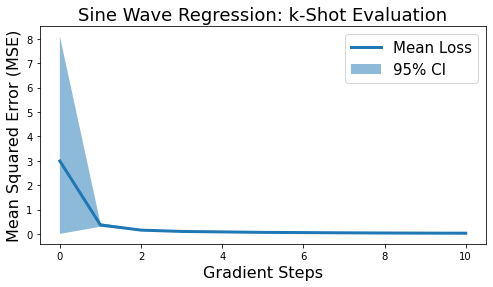

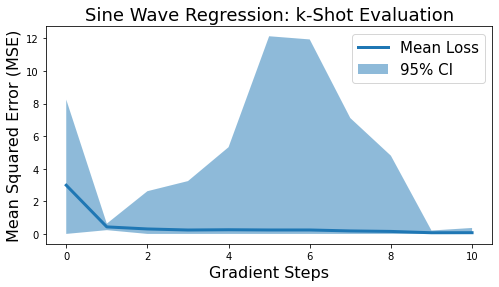

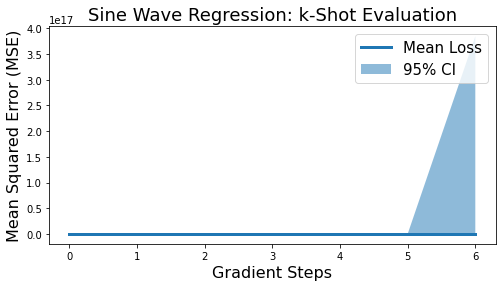

In [3]:
'''
Handling computation graphs and second-order backprop help and partial inspiration from: 
- https://discuss.pytorch.org/t/how-to-save-computation-graph-of-a-gradient/128286/2 
- https://discuss.pytorch.org/t/when-do-i-use-create-graph-in-autograd-grad/32853/3 
- https://lucainiaoge.github.io/download/PyTorch-create_graph-is-true_Tutorial_and_Example.pdf
- https://www.youtube.com/watch?v=IkDw22a8BDE
- https://discuss.pytorch.org/t/how-to-manually-update-network-parameters-while-keeping-track-of-its-computational-graph/131642/2
- https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/3
- https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
- https://higher.readthedocs.io/en/latest/toplevel.html

Neural network configuration and helper class functions copied directly from 
-https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Note, different ways to refer to the task-specific vs. meta/aggregate updates to the parameters
Sometimes called "inner" and "outer" loop, respectively
Here, refered to as "task_specific" and "agg"/meta" (the latter, for consistency w/ ocariz code)
'''

act_functions = ["ReLU", "ELU", "SELU"]

N = 1 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
K = 10 # number of samples to draw from the task

num_epochs = 10000

num_k_shots = 11
num_eval=1000

printing_step = 2500

for act_func in act_functions: 

    #Instantiate the model network
    model = Neural_Network(activation_func = act_func)
    # move to the current device (GPU or CPU)
    # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
    model.to(device)

    #Used to store the validation losses
    metaLosses = []
    metaValLosses = []

    #Meta-optimizer for the outer loop
    meta_optimizer = torch.optim.Adam(model.parameters(), lr = lr_meta)

    #Inner optimizer, we were doing this by hand previously
    inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)

    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        # store loss over all tasks to then do a large meta-level update of initial params
        # idea/help from video: https://www.youtube.com/watch?v=IkDw22a8BDE
        meta_loss = None

        waves = dataset.get_meta_train_batch(task_batch_size=T)

        #Loop through all of the tasks
        for i, T_i in enumerate(waves): 
            train_eval_info = task_specific_train_and_eval(model, T_i, inner_loop_optimizer, criterion, K=K, N=N)
            held_out_task_specific_loss = train_eval_info[0]
            if meta_loss is None: 
                meta_loss = held_out_task_specific_loss
            else:
                meta_loss += held_out_task_specific_loss

        meta_optimizer.zero_grad()
        meta_loss /= T
        meta_loss.backward()
        meta_optimizer.step()
        metaLosses.append(meta_loss.item())

        # validation 
        val_wave = dataset.get_meta_val_batch(task_batch_size=1)[0]
        val_train_eval_info = task_specific_train_and_eval(model, val_wave, inner_loop_optimizer, criterion, K=K, N=N)
        val_loss = val_train_eval_info[0]
        metaValLosses.append(val_loss.item())

        if epoch % printing_step == 0:
            print("Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
            # saving model help from: 
            # https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save(model.state_dict(), f"baseline_maml_act_{act_func}.pt")


    print("Current activation function: ", act_func)
    res = analysis_utils.k_shot_evaluation(model, dataset, criterion, num_k_shots=num_k_shots, K=K, num_eval=num_eval,
                            file_tag=f"baseline_maml_act_{act_func}.pdf", seed=7)      
        

Iter =  0  Current Loss 3.467756748199463  Val Loss:  9.868555068969727
Iter =  2500  Current Loss 1.3774303424744452  Val Loss:  1.2520060010983503
Iter =  5000  Current Loss 1.0197943533880427  Val Loss:  0.9301428091380346
Iter =  7500  Current Loss 0.8531201142952325  Val Loss:  0.7801603888525083
Current activation function:  LeakyReLU
shape:  (1000, 11)
Step: 0, Error: 2.988334091981873, Var: 5.175397491897092
Step: 1, Error: 0.3579546527445782, Var: 0.07252367253446389
Step: 5, Error: 0.05541007517767139, Var: 0.006998699420860011
Iter =  0  Current Loss 5.5030517578125  Val Loss:  12.808570861816406
Iter =  2500  Current Loss 1.184365857605551  Val Loss:  1.1507504514555578
Iter =  5000  Current Loss 0.878057200478759  Val Loss:  0.8376438457326909
Iter =  7500  Current Loss 0.766171688823569  Val Loss:  0.7182723611542868
Current activation function:  SELU
shape:  (1000, 11)
Step: 0, Error: 2.9858864027634264, Var: 5.245507730954
Step: 1, Error: 0.42341396914422513, Var: 0.179

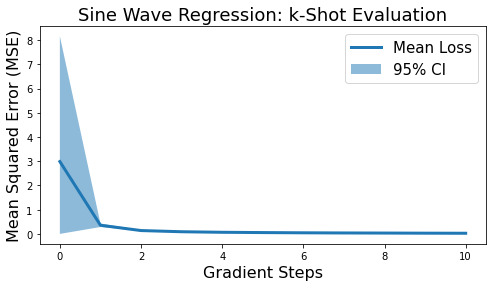

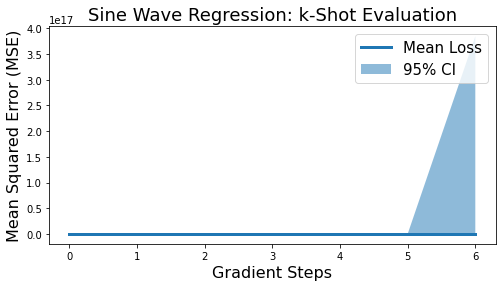

In [3]:
'''
Handling computation graphs and second-order backprop help and partial inspiration from: 
- https://discuss.pytorch.org/t/how-to-save-computation-graph-of-a-gradient/128286/2 
- https://discuss.pytorch.org/t/when-do-i-use-create-graph-in-autograd-grad/32853/3 
- https://lucainiaoge.github.io/download/PyTorch-create_graph-is-true_Tutorial_and_Example.pdf
- https://www.youtube.com/watch?v=IkDw22a8BDE
- https://discuss.pytorch.org/t/how-to-manually-update-network-parameters-while-keeping-track-of-its-computational-graph/131642/2
- https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/3
- https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
- https://higher.readthedocs.io/en/latest/toplevel.html

Neural network configuration and helper class functions copied directly from 
-https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Note, different ways to refer to the task-specific vs. meta/aggregate updates to the parameters
Sometimes called "inner" and "outer" loop, respectively
Here, refered to as "task_specific" and "agg"/meta" (the latter, for consistency w/ ocariz code)
'''

act_functions = ["LeakyReLU", "SELU"]

N = 1 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
K = 10 # number of samples to draw from the task

num_epochs = 10000

num_k_shots = 11
num_eval=1000

printing_step = 2500

for act_func in act_functions: 

    #Instantiate the model network
    model = Neural_Network(activation_func = act_func)
    # move to the current device (GPU or CPU)
    # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
    model.to(device)

    #Used to store the validation losses
    metaLosses = []
    metaValLosses = []

    #Meta-optimizer for the outer loop
    meta_optimizer = torch.optim.Adam(model.parameters(), lr = lr_meta)

    #Inner optimizer, we were doing this by hand previously
    inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)

    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        # store loss over all tasks to then do a large meta-level update of initial params
        # idea/help from video: https://www.youtube.com/watch?v=IkDw22a8BDE
        meta_loss = None

        waves = dataset.get_meta_train_batch(task_batch_size=T)

        #Loop through all of the tasks
        for i, T_i in enumerate(waves): 
            train_eval_info = task_specific_train_and_eval(model, T_i, inner_loop_optimizer, criterion, K=K, N=N)
            held_out_task_specific_loss = train_eval_info[0]
            if meta_loss is None: 
                meta_loss = held_out_task_specific_loss
            else:
                meta_loss += held_out_task_specific_loss

        meta_optimizer.zero_grad()
        meta_loss /= T
        meta_loss.backward()
        meta_optimizer.step()
        metaLosses.append(meta_loss.item())

        # validation 
        val_wave = dataset.get_meta_val_batch(task_batch_size=1)[0]
        val_train_eval_info = task_specific_train_and_eval(model, val_wave, inner_loop_optimizer, criterion, K=K, N=N)
        val_loss = val_train_eval_info[0]
        metaValLosses.append(val_loss.item())

        if epoch % printing_step == 0:
            print("Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
            # saving model help from: 
            # https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save(model.state_dict(), f"baseline_maml_act_{act_func}.pt")


    print("Current activation function: ", act_func)
    res = analysis_utils.k_shot_evaluation(model, dataset, criterion, num_k_shots=num_k_shots, K=K, num_eval=num_eval,
                            file_tag=f"baseline_maml_act_{act_func}.pdf", seed=7)      
        